# AdaBoost

Implementation of the AdaBoost algorithm for classification, as described in _Hastie, Trevor, Robert, Tibshirani and J. H. Friedman. 2009. The Elements of Statistical Learning: Data Mining, Inference, and Prediction. New York: Springer_. The algorithm consists of a boosting technique, that takes a weak classifier,e.g. decision bump, and improves its performance by applying weights to each sucessive prediction on each iteration. This implementation of the AdaBoost only works for classification problems with $y \in \{-1,1\} $.

## The Algorithm

Dependencies

In [10]:
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.tree  import DecisionTreeClassifier

Defining a simple misclassification function.

In [11]:
def misclassification(y,prediction):
    """
    Inputs:
        y: int
            Input a single value of the output variable y.
        prediction: int
            Input a single valut of the predicted output.
    Returns:
        misclassifications: array
            Output 1 if the values do not match and 0 if they do.
    """
    y=y.reshape((-1,1))
    prediction = prediction.reshape((-1,1))
    misclassifications = 1*(y != prediction)
    return misclassifications
    

### Implementation

In [12]:
def adaboost_m1(x,y,M):
    """
    AdaBoost algorithm for weak classifiers.
    Inputs:
        x: array
            input the array of input points
        y: array
            input the array of output points, with y E {-1,1}
        M: int
            input number of iterations for the algorithm
    Returns:
        alphas: array
            outputs the array of classifier/stump weights(alphas)calculated by the AdaBoost
        stumps: list
            outputs the list of M classifiers that were fitted over all iterations
        weighted_error: array
            outputs the array of weighted misclassification error for every iteration M.
    """
    alphas = np.zeros((M,1)) 
    predictions_train = np.zeros((len(y),M)) 
    staged_weights = np.zeros((len(y),M)) 
    weighted_error = np.zeros((M,1)) 
    stumps = list()
    for i in range(len(y)):
        staged_weights[i,0] = 1/len(y)
    for m in range(M):
        curr_weights = staged_weights[:,m]
        stump = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)
        stump = stump.fit(x,y,sample_weight=curr_weights)
        predictions_train[:,m] = stump.predict(x)
        curr_weights = curr_weights.reshape((-1,1))
        weighted_misclassification = curr_weights * misclassification(y,predictions_train[:,m])
        weighted_error[m] = np.sum(weighted_misclassification)/np.sum(curr_weights)
        alphas[m] = np.log((1 - weighted_error[m])/weighted_error[m])
        curr_weights = curr_weights * np.exp(alphas[m] * misclassification(y,predictions_train[:,m]))
        curr_weights = curr_weights.reshape((-1,))
        if m + 1 < M:
            staged_weights[:,m+1] = curr_weights
        stumps.append(stump)
    return alphas, stumps, weighted_error
class adaboost:
    """
    AdaBoost algorithm for weak classifiers, that can fit discrete classification problems.
    """
    def __init__(self,M):
        """
        Initialize self.
        Inputs:
            M: int
                input number of iterations for the algorithm
        """
        self.M = M 
    def fit(self,x,y):
        """
        Fits the AdaBooster on a given dataset.
        Inputs:
            x: array
                input the array of input points
            y: array
                input the array of output points, with y E {-1,1}   
        """
        self.x = x 
        self.y = y 
        result = adaboost_m1(self.x,self.y,self.M) 
        self.alphas = result[0]
        self.stumps = result[1]
        self.weight_error = result[2]
    def predict(self,x):
        """
        Makes a prediction based on the weights and classifiers calculated by the Adabooster
        Inputs:
            x: array_like
                input the array of input points
        Returns:
            self.predict: array_like
                outputs the array of predictions
        """   
        indiv_predictions = np.array([self.classifier.predict(x) for self.classifier in self.stumps])
        prediction = indiv_predictions.T @ self.alphas         
        prediction = np.sign(prediction)
        return prediction
    def alphas(self):
        """
        Gives the weights calculated by the AdaBooster
        """
        return self.alphas

## Example

### Generating a toy dataset to test the algorithm

This will be a classification dataset, with 2 features and 100 samples.

In [13]:
from sklearn.datasets import make_gaussian_quantiles
def make_toy_dataset(n: int = 100, random_seed: int = None):
    """ Generate a toy dataset for evaluating AdaBoost classifiers """
    
    n_per_class = int(n/2)
    
    if random_seed:
        np.random.seed(random_seed)

    X, y = make_gaussian_quantiles(n_samples=n, n_features=2, n_classes=2)
    
    return X, y*2-1

X, y = make_toy_dataset(n=100, random_seed=10)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

Defining a plot function(credits to:https://geoffruddock.com/adaboost-from-scratch-in-python/)

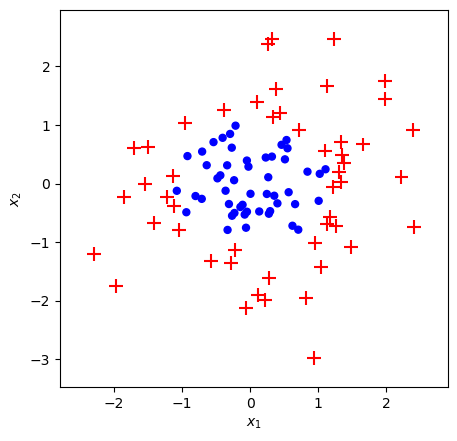

In [14]:
import matplotlib.pyplot as plt
from typing import Optional
import matplotlib as mpl
def plot_adaboost(X: np.ndarray,
                  y: np.ndarray,
                  clf=None,
                  sample_weights: Optional[np.ndarray] = None,
                  annotate: bool = False,
                  ax: Optional[mpl.axes.Axes] = None) -> None:
    """ Plot ± samples in 2D, optionally with decision boundary """

    assert set(y) == {-1, 1}, 'Expecting response labels to be ±1'

    if not ax:
        fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
        fig.set_facecolor('white')

    pad = 1
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad

    if sample_weights is not None:
        sizes = np.array(sample_weights) * X.shape[0] * 100
    else:
        sizes = np.ones(shape=X.shape[0]) * 100

    X_pos = X[y == 1]
    sizes_pos = sizes[y == 1]
    ax.scatter(*X_pos.T, s=sizes_pos, marker='+', color='red')

    X_neg = X[y == -1]
    sizes_neg = sizes[y == -1]
    ax.scatter(*X_neg.T, s=sizes_neg, marker='.', c='blue')

    if clf:
        plot_step = 0.01
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # If all predictions are positive class, adjust color map acordingly
        if list(np.unique(Z)) == [1]:
            fill_colors = ['r']
        else:
            fill_colors = ['b', 'r']

        ax.contourf(xx, yy, Z, colors=fill_colors, alpha=0.2)

    if annotate:
        for i, (x, y) in enumerate(X):
            offset = 0.05
            ax.annotate(f'$x_{i + 1}$', (x + offset, y - offset))

    ax.set_xlim(x_min+0.5, x_max-0.5)
    ax.set_ylim(y_min+0.5, y_max-0.5)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
plot_adaboost(X,y)

### Model performance 

#### Accuracy on the Test set

First let's evaluate the performance of a single decision stump on the dataset.

In [15]:
stump = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)
stump.fit(X_train,Y_train)
prediction = stump.predict(X_test)
counter = np.sum(misclassification(prediction,Y_test))
print(f"The accuracy of the decision stump on the test set is: {np.round(((len(Y_test) - counter)/len(Y_test))*100,2)}%")

The accuracy of the decision stump on the test set is: 55.0%


We can see that the stump is clearly a weak classifier, since its test accuracy is ~50%.

Now let's evaluate the performance of the decision stump after the boosting operation.

In [16]:
boost = adaboost(40)
boost.fit(X_train,Y_train)
prediction = boost.predict(X_test)
counter = np.sum(misclassification(prediction,Y_test))
print(f"The accuracy of the boosted decision stump on the test set is: {np.round(((len(Y_test) - float(counter))/len(Y_test))*100,2)}%")


The accuracy of the boosted decision stump on the test set is: 95.0%


And thus the efficiency of the AdaBoost algorithm is proved . It has increased the accuracy of the decision stump by ~40%, which elevates it from a weak classifier(one that is analogous to random guessing) to a pretty strong classifier, with an accuracy of more than 90%.

Now let's plot the test error of the model at each iteration M. Although the graph shows a continuous line, the relationship between these variables is discrete, the continuous visualization is utilized only to give a better intuition on the subject. The actual discrete relationship is also shown as red dots.

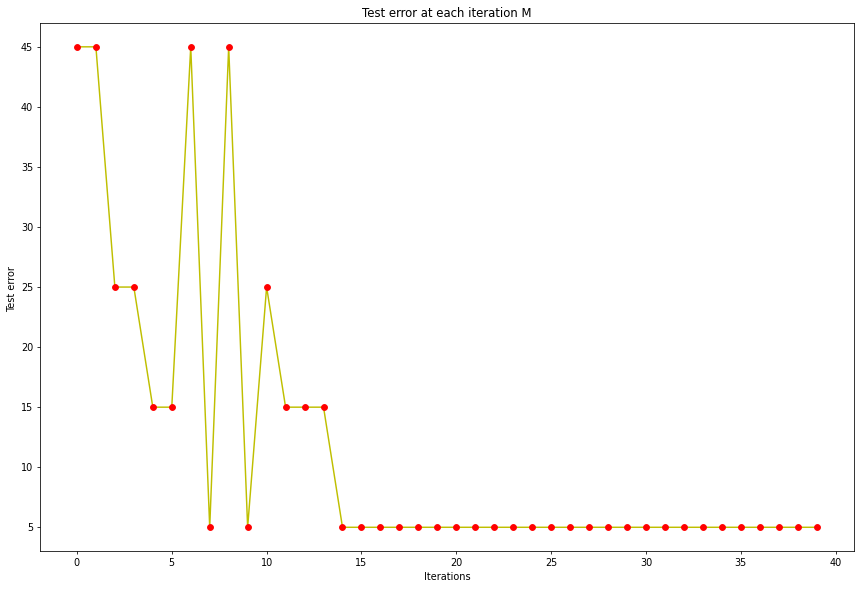

In [17]:
test_error_list = list()
iterations = np.array((range(40)))
for i in range(40):
    boost = adaboost(i+1)
    boost.fit(X_train,Y_train)
    prediction = boost.predict(X_test)
    counter = np.sum(misclassification(Y_test,prediction))
    test_error_list.append(((counter)/len(Y_test))*100)
plt.figure(figsize=(15,10),dpi=70)
plt.title('Test error at each iteration M')
plt.xlabel('Iterations')
plt.ylabel('Test error ')
plt.plot(iterations,test_error_list, 'y')
plt.plot(iterations,test_error_list,'ro')


We can see that after the 14th iteration, the test error remais constant at 5%, and thus the optimal number of iterations for this particular dataset is 14.

#### Visualizing the relationship between weak classifiers and their respective weights

Now let's plot the values for all the classifier weights(alphas) and the training error(weighted misclassification) for each of the M iterations. Every point in the graph represents an individual classifier, that 

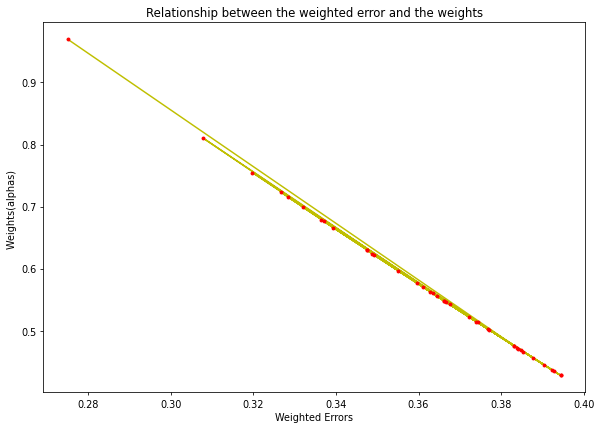

In [18]:
alphas = boost.alphas
weighted_error = boost.weight_error
plt.figure(figsize=(10,7),dpi=70)
plt.tick_params(axis='x', which='major', labelsize=10)
plt.title('Relationship between the weighted error and the weights')
plt.xlabel('Weighted Errors')
plt.ylabel('Weights(alphas) ')
plt.plot(weighted_error,alphas,'y')
plt.plot(weighted_error,alphas,'ro', ms=3)


We can see that the iterations with the lowest weighted error have the highest values of alpha, which makes sense, since the adaboost algorithm is based on weighting the influence of a sequence of iterations based on their respective weighted error.